# 1. Introduction

## 1.1 Source

source: https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones

## 1.2 Description of datast

Is it possible to predict the star rating of an Amazon review given the text of that review? We want to try to answer that question using a collection of 400,000 Amazon reviews of unlocked mobile phones as my dataset. 

----| Metric | Description |
----|--------|:-------------|
----| *Product Name*| Name of The Product |
----| *Brand Name*| Manufacturer of the Product |
----| *Price*| Price of the Product|
----| *Rating*| Rating Given for the product|
----| *Reviews*| Review left by the Customer|
----| *Review Votes*| Number of People who found the Review Helpful |

## Imports and setup

In [1]:
conda install -c conda-forge wordcloud


Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Print stuff inline
%matplotlib inline

# Imports
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from IPython.display import display
from sklearn import model_selection
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.naive_bayes import MultinomialNB
from wordcloud import STOPWORDS, WordCloud
import sys

## Helper functions

In [3]:
# http://stackoverflow.com/questions/33181846/programmatically-convert-pandas-dataframe-to-markdown-table
# This function converts a pandas dataframe to a markdown table.
def pandas_df_to_markdown_table(df):
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    return "|" + df_formatted.to_csv(line_terminator="|\n|", sep="|", index=False)[:-2]

## 1.3 Load dataset

In [4]:
# Load he data and drop columns we don't care about.
try:
    data = pd.read_csv("/Users/surya/Documents/PR Assignments/PRProject/Amazon_Unlocked_Mobile.csv")
    data.drop(['Product Name', 'Brand Name','Review Votes'], axis = 1, inplace = True)
    print ("{} Amazon mobile phone reviews with {} features each.".format(*data.shape))
except:
    print ("You need to download the dataset from https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones")

413840 Amazon mobile phone reviews with 3 features each.


## 1.4 Data Cleaning and pre processing

In [5]:
def clean_text(string): 
    # Turn warnings off because BeautifulSoup give some we don't care about
    warnings.filterwarnings('ignore')
    
    # Remove xml formatting.
    review_text = BeautifulSoup(string, "lxml").get_text() 
    
    # Turn warnings back on
    warnings.resetwarnings()
    
    # Remove all characters not in the English alphabet
    string = re.sub("[^a-zA-Z]"," ", string)
    
    # Set all characters to lower case.
    string = string.lower()
    
    return string

## 1.5 Handling Missing Values

In [6]:
# Sometimes people leave ratings without reviews. We are going to ignore empty reviews.
data = data[data['Reviews'].isnull()==False]

# Get the ratings column.
ratings = data['Rating']

# Get the reviews column, and clean the reviews.
reviews = map(clean_text, data['Reviews'])

# 2 Final goal

Is it possible to predict the star rating of an Amazon review given the text of that review? We want to try to answer that question using a collection of 400,000 Amazon reviews of unlocked mobile phones as my dataset. We think it is interesting to see if the sentiment of a review can be decided from the text of the review itself.
The problem of determining the sentiment of text is not new. Research was done to try to extract sentiment from movie reviews. They tried to predict whether the review was positive or negative based on the text. They found that one of the main difficulties with sentiment extraction is that it requires more understanding of the text than traditional topic-based categorization. Topic-based categorization relies on finding keywords in text, however sentiment can be expressed more subtly.

## 3 Exploratory Data Analysis

## 3.1 Visualize your data

In [7]:
data.head(5)

,Price,Rating,Reviews
0,199.99,5,I feel so LUCKY to have found this used (phone...
1,199.99,4,"nice phone, nice up grade from my pantach revu..."
2,199.99,5,Very pleased
3,199.99,4,It works good but it goes slow sometimes but i...
4,199.99,4,Great phone to replace my lost phone. The only...


In [8]:
data.tail(5)

,Price,Rating,Reviews
413835,79.95,5,another great deal great price
413836,79.95,3,Ok
413837,79.95,5,Passes every drop test onto porcelain tile!
413838,79.95,3,I returned it because it did not meet my needs...
413839,79.95,4,Only downside is that apparently Verizon no lo...


In [9]:
data.describe()

,Price,Rating
count,407848.000000,413778.000000
mean,226.867148,3.819609
std,273.019444,1.548212
min,1.730000,1.000000
25%,79.990000,3.000000
50%,144.710000,5.000000
75%,269.990000,5.000000
max,2598.000000,5.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413778 entries, 0 to 413839
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Price    407848 non-null  float64
 1   Rating   413778 non-null  int64  
 2   Reviews  413778 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 12.6+ MB


## 3.2 plotting histograms

Text(0, 0.5, 'Count')

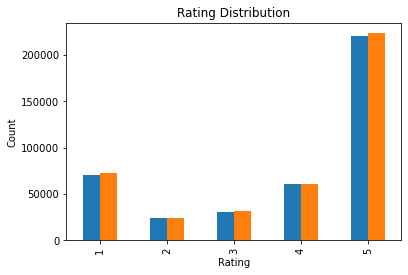

In [11]:
# https://github.com/ipython/ipython/issues/9242
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

# Create and print a rating distribution graph.
rating_distribution_plt = data.groupby(['Rating']).count().plot(kind='bar', legend=None, title="Rating Distribution")
rating_distribution_plt.set_xlabel("Rating")
rating_distribution_plt.set_ylabel("Count")

Text(0, 0.5, 'Count')

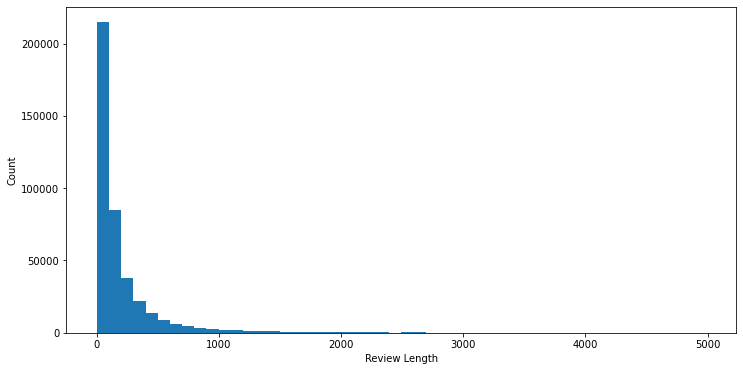

In [12]:
# Create and print a Reviews length distribution graph.
review_length_distribution_plt = pd.DataFrame(data["Reviews"].str.len())
review_length_distribution_plt = review_length_distribution_plt[review_length_distribution_plt.Reviews < 5000]
review_length_distribution_plt.groupby(["Reviews"])
review_length_distribution_plt = review_length_distribution_plt.plot(kind='hist', 
                                                                     legend=None, 
                                                                     bins=50, 
                                                                     figsize=(12, 6))
review_length_distribution_plt.set_xlabel("Review Length")
review_length_distribution_plt.set_ylabel("Count")


## 3.3 plotting variables

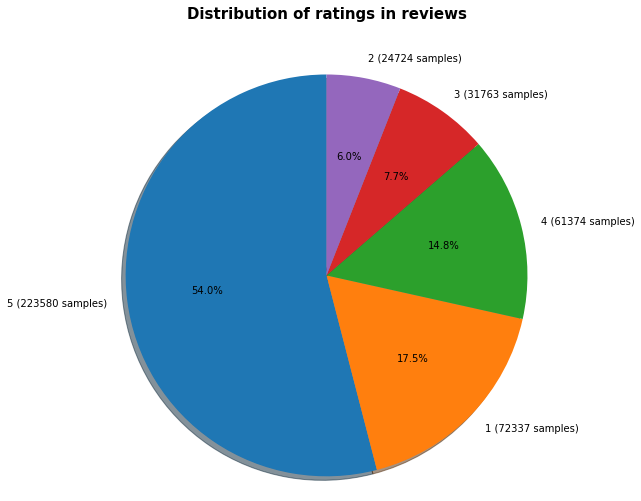

In [13]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({data["Rating"].value_counts()[k]} samples)' for k in data['Rating'].value_counts().keys()]
sizes = dict(data['Rating'].value_counts()).values()

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Distribution of ratings in reviews",pad=40, fontweight='bold', fontsize=15)
plt.show();

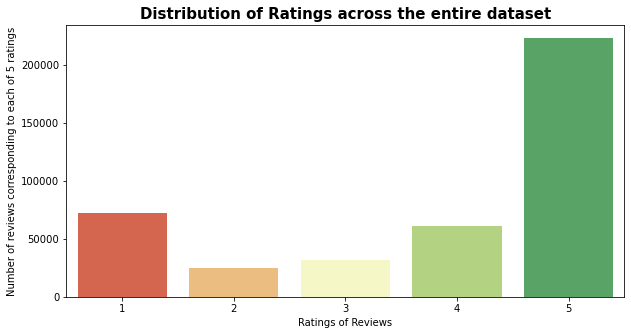

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(10,5))
sns.countplot(data['Rating'], palette=sns.color_palette("RdYlGn", 5))
plt.title("Distribution of Ratings across the entire dataset", fontweight='bold', fontsize=15)
plt.xlabel("Ratings of Reviews")
plt.ylabel("Number of reviews corresponding to each of 5 ratings")
plt.show();

## 3.4 correlation analysis

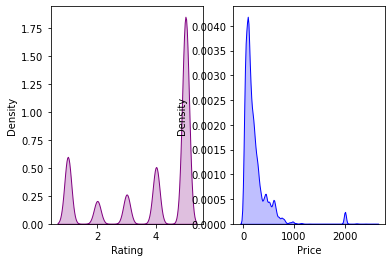

In [15]:
fig, ax =plt.subplots(1,2)
sns.kdeplot(data['Rating'],shade=True,color="purple",ax=ax[0])
sns.kdeplot(data['Price'],shade=True,color="blue",ax=ax[1])
fig.show()

In [16]:
Expensive=data[data['Price']>250]
N_Expensive=data[data['Price']<250]

In [17]:
len(Expensive)

110641

In [18]:
len(N_Expensive)

296624

In [19]:
(len(Expensive)/float(len(Expensive)+len(N_Expensive)))*100

27.166832406418422

<AxesSubplot:xlabel='Rating', ylabel='Density'>

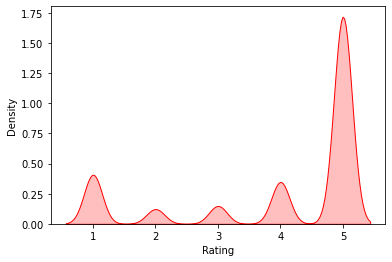

In [20]:
sns.kdeplot(Expensive['Rating'],shade=True,color="red")

<AxesSubplot:xlabel='Rating', ylabel='Density'>

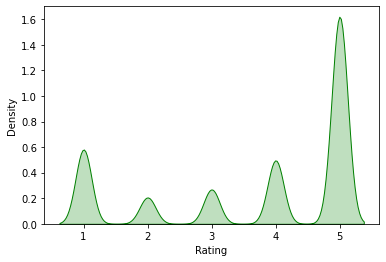

In [21]:
sns.kdeplot(N_Expensive['Rating'],shade=True,color="green")

Overall , It could be infered that pricing has not much effect on the ratings of phones.

In [22]:
data.drop(['Price'], axis = 1, inplace = True)

## 3.5 Observation

Observation:

-68 percent of the reviews in the dataset are positive reviews having ratings >3 (4 and 5)

-23 percent of the reviews in the dataset are negative reviews having ratings <3 (1 and 2)

-Remaining 8 percent reviews have a rating of 3.

Since a major portion of the reviews are positive, we can say that most of the users have a good experience with their purchases.


## 3.6 Feature Extraction

In [23]:
vectorizer = TfidfVectorizer(
        min_df=2,               # Ignore phrases that are in fewer than 2 reviews
        max_df=0.95,            # Ignore phrases that are in 95% of reviews
        ngram_range = (1,4),    # Take phrases between 1 and 4 words
        stop_words = 'english', # Remove common English words
        # max_features = 300    # The max features amount of features. Set this to 
                                # something small when getting most relevant phrases to 
                                # prevent crases (We have to do some array conversions which 
                                # take a lot of memory)
        )

# Extract features from reviews.
review_features = vectorizer.fit_transform(reviews)

### Get most relevant  phrases

In [24]:
def get_most_relevant_phrases():
    # Convert features into an array
    feature_array = np.array(vectorizer.get_feature_names()) 
    
    # Sort features by weight.
    tfidf_sorting = np.argsort(review_features.toarray()).flatten()[::-1]
    
    # Get the top eight most weighted features.
    top_n = feature_array[tfidf_sorting][:8]
    return top_n

In [25]:
# It's important not to run this unless you set max_features in TfidfVectorizer to something small. 
# The array conversions can take a lot of memory.
# print (get_most_relevant_phrases())

## Train/Test Split

In [26]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                            review_features,   # The features we created from the reviews
                                            ratings,           # The ratings we are trying to predict
                                            stratify=ratings,  # We have an imbalance of 5-star reviews, so let's stratify
                                            random_state = 12, # Random seed
                                            test_size = 0.3    # We need to save 30% of the data for testing
                                            )
print (X_train.shape)

(289644, 3553748)


## Get example reviews

In [27]:
# Find a random set of reviews so we can see how each model performs on it.
example_review_set = pd.DataFrame(y_test[191:197].index).join(data, on=0)
print(pandas_df_to_markdown_table(example_review_set[['Rating','Reviews']]))

|Rating|Reviews|
|---|---|
|5|Excellent product! It's working in Chile with Argentinian and Italian SIM cards. Very good battery life (almost 7 days with regular use).|
|4|Purchased this phone for my son after breaking his iphone. We're pleased with the RCA and he hasn't had any issues with the phone, usage or connectivity and we're on the AT&T network.|
|4|My daughter loves her new phone.|
|2|Stopped working after 6 days. Amazon refunded money with no issues.|
|1|No lo recomiendo. No funciona en Venezuela. No viene con idioma español solo ingles y francés.Not recommend. Does not work in Venezuela.|
|3|I love the keyboard on the phone/and wifi, but the volume is not that great and earpiece did not work with phone.|


# 4. Final Analysis/ Model building

### Benchmark model

For the benchmark, we are not going to do any parameter tuning; we are going to use sklearns default parameters. As we will see, logistic regression does fairly well right out of the box.

In [ ]:
clf_benchmark = LogisticRegression(random_state=22).fit(X_train, y_train)
print( classification_report(y_test, clf_benchmark.predict(X_test), digits=4))

### Other models 

Create an unoptimized MultinomialNB classifier.

In [15]:
clf_NB = MultinomialNB()
clf_NB.fit(X_train, y_train)
print( classification_report(y_test, clf_NB.predict(X_test), digits=4))

              precision    recall  f1-score   support

           1     0.8839    0.7198    0.7934     21701
           2     0.9990    0.1302    0.2304      7417
           3     0.9976    0.1322    0.2335      9529
           4     0.9982    0.1770    0.3007     18412
           5     0.6637    0.9991    0.7976     67075

    accuracy                         0.7099    124134
   macro avg     0.9085    0.4317    0.4711    124134
weighted avg     0.7975    0.7099    0.6460    124134



Create an unoptimized SGDClassifier classifier.

In [16]:
clf_SGD = SGDClassifier(random_state=22)
clf_SGD.fit(X_train, y_train)
print( classification_report(y_test, clf_SGD.predict(X_test), digits=4))

              precision    recall  f1-score   support

           1     0.6899    0.7996    0.7407     21701
           2     0.9188    0.1068    0.1913      7417
           3     0.8589    0.1111    0.1968      9529
           4     0.7763    0.0505    0.0948     18412
           5     0.6924    0.9878    0.8142     67075

    accuracy                         0.6959    124134
   macro avg     0.7873    0.4112    0.4076    124134
weighted avg     0.7307    0.6959    0.6100    124134



### Refinement 

The alpha paramter determines what value we give the when we see a feature that we haven’t encountered in the testing data. We can’t use 0 because MultinomialNB multiplies these probabilities together and our whole prediction becomes 0. For example, if we find a 5-star review with a single word that we’ve never seen in a 5-star review before we don’t want our prediction to be 0.

In [17]:
parameters = { 'alpha': [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2] }
clf_NB_refined = GridSearchCV(MultinomialNB(), parameters)
clf_NB_refined.fit(X_train, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75,
                                   2]})

In [18]:
# Print out the parameters GridSearchCV decided on.
clf_NB_refined.best_params_

{'alpha': 0.1}

The SGDClassifier guide on sklearn’s site gives some reasonable ranges to search over for alpha and n_iter. It recommends the range `10.0**-np.arange(1,7)` for alpha and `np.ceil(10**6 / n)` (n is the size of the training set) as a first guess for n_iter. Since our training size has 289,645 rows, it recommends a n_iter of 3, so we are going to try a couple of values around 3. For penalty, we are just going to try every possible value. Finally, we are going to try three loss functions: hinge (linear SVM), log (logistic regression), perceptron (perceptron algorithm).

In [19]:
#parameters = [{ 'loss': ['hinge', 'log_loss', 'perceptron'], 
                #'alpha': 10.0**-np.arange(1,7),
                #'penalty': ['l1', 'l2', 'elasticnet'],
                #'max_iter': [2000,3000,4000,5000] }]
#clf_SGD_refined = GridSearchCV(SGDClassifier(random_state=22), parameters)
#clf_SGD_refined.fit(X_train, y_train)

In [20]:
# Print out the parameters GridSearchCV decided on.
#clf_SGD_refined.best_params_

# 5 Evaluating the results

### Accuracy and F1-Scores

In [21]:
print("\nAccuracy: ")
print( "LogisticRegression: " + repr(accuracy_score(y_test, clf_benchmark.predict(X_test))) )
print( "MultinomialNB:      " + repr(accuracy_score(y_test, clf_NB_refined.predict(X_test))) )
#print( "SGDClassifier:      " + repr(accuracy_score(y_test, clf_SGD_refined.predict(X_test))) )

print("\nclassification reports: ")
print( "LogisticRegression: " )
print( classification_report(y_test, clf_benchmark.predict(X_test), digits=4))
print( "MultinomialNB: " ) 
print( classification_report(y_test, clf_NB_refined.predict(X_test), digits=4))
#print( "SGDClassifier: " ) 
#print( classification_report(y_test, clf_SGD_refined.predict(X_test), digits=4))


Accuracy: 
LogisticRegression: 0.780003866789115
MultinomialNB:      0.849299950053974

classification reports: 
LogisticRegression: 
              precision    recall  f1-score   support

           1     0.7388    0.8967    0.8101     21701
           2     0.8290    0.3073    0.4484      7417
           3     0.7386    0.3721    0.4949      9529
           4     0.6832    0.3836    0.4913     18412
           5     0.8069    0.9613    0.8774     67075

    accuracy                         0.7800    124134
   macro avg     0.7593    0.5842    0.6244    124134
weighted avg     0.7727    0.7800    0.7534    124134

MultinomialNB: 
              precision    recall  f1-score   support

           1     0.8570    0.9093    0.8824     21701
           2     0.9379    0.6024    0.7336      7417
           3     0.8819    0.5949    0.7105      9529
           4     0.8536    0.5524    0.6707     18412
           5     0.8383    0.9748    0.9014     67075

    accuracy                      

### Performance on example reviews

In [22]:
# Create features on the example reviews.
example_reviews_features = vectorizer.transform(example_review_set.Reviews)

# Predict the reviews with each model.
predicted_ratings_0 = np.hstack(map(clf_benchmark.predict, example_reviews_features))
predicted_ratings_1 = np.hstack(map(clf_NB_refined.predict, example_reviews_features))
#predicted_ratings_2 = np.hstack(map(clf_SGD_refined.predict, example_reviews_features))

# We don't need to print the whole review out; just enough to compare to the first table.
def shorten_text(x):
    length = 50
    r = x[:length]
    if len(x) > length:
        r = r + "..."
    return r

# Create a table of reviews.
example_review_table = pd.DataFrame( { 
              'Rating': example_review_set.Rating,
              'LR': predicted_ratings_0,
              'MNB': predicted_ratings_1,
              'Review': map(shorten_text, example_review_set.Reviews)
              }
            )

# Reorder columns.
example_review_table = example_review_table[['Rating', 'LR','MNB', 'Review']]

# Print reviews in a markdown table.
print (pandas_df_to_markdown_table(example_review_table))

/var/folders/cc/vshs378n5mj8c5pfq8c2bfs40000gn/T/ipykernel_32982/3708270482.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predicted_ratings_0 = np.hstack(map(clf_benchmark.predict, example_reviews_features))
/var/folders/cc/vshs378n5mj8c5pfq8c2bfs40000gn/T/ipykernel_32982/3708270482.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predicted_ratings_1 = np.hstack(map(clf_NB_refined.predict, example_reviews_features))


|Rating|LR|MNB|Review|
|---|---|---|---|
|5|5|5|Excellent product! It's working in Chile with Arge...|
|4|5|5|Purchased this phone for my son after breaking his...|
|4|5|5|My daughter loves her new phone.|
|2|2|2|Stopped working after 6 days. Amazon refunded mone...|
|1|5|5|No lo recomiendo. No funciona en Venezuela. No vie...|
|3|3|4|I love the keyboard on the phone/and wifi, but the...|


### Confusion Matrices

In [23]:
# A function to help create confusion matrices.
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure( figsize=(9,4), facecolor='white')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(ratings)))
    plt.xticks(tick_marks, set(ratings), rotation=45)
    plt.yticks(tick_marks, set(ratings))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
# A function to create and print confusion matrix.
def create_and_print_confusion_matrix(y_test, predicted, title):
    cm = confusion_matrix(y_test, predicted)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cm, title) 
    plt.show()

<Figure size 640x480 with 0 Axes>

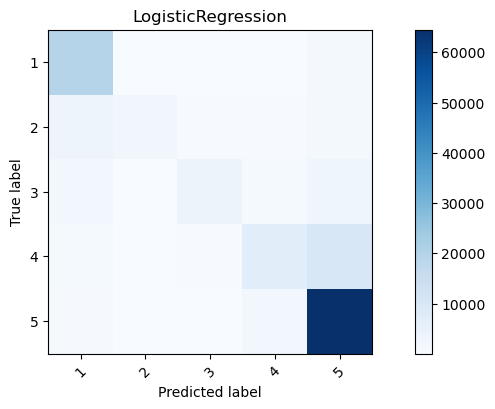

In [25]:
# Create logistic regression confusion matrix.
create_and_print_confusion_matrix(y_test, clf_benchmark.predict(X_test), "LogisticRegression")

<Figure size 640x480 with 0 Axes>

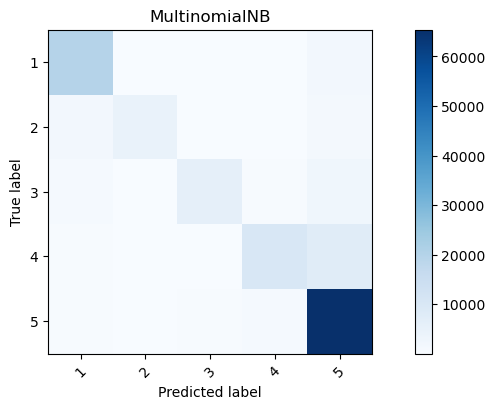

In [26]:
# Create MultinomialNB confusion matrix.
create_and_print_confusion_matrix(y_test, clf_NB_refined.predict(X_test),"MultinomialNB")

# 6. Summary


The final stochastic gradient descent learning model (MultinomialNB) has a F1-Score of 0.8392, this is much better than the benchmark model which has a score of 0.7534. We can observe these from results.


We can see that the classifiers have a hard time differentiating between 4 and 5 star reviews and 2 and 1 star reviews. One of the reviews has Spanish words, almost all the reviews are English so it’s not surprising that that all three classifier got that predictions wrong.
The final model does a good job of finding the general sentiment of a review. If you want to determine if a review is positive or negative, then this model is probably good enough. If you want a model that can differentiate between similar star ratings (like 3-star and 4-star reviews), then more work needs to be done.

## 6.2 Improvements

All two models have low recall on reviews with star ratings between 2 and 4. Even for a human, it’s difficult to differentiate between these reviews. The difference between a 3-star and 4-star review is very subtle. A good place to look for improvements are ways to improve recall for these mid-star reviews.
A solution not explored in this report is a neural network. Many people have found success using neural networks for text classification problems. A good candidate would be the use of the Keras9 python library. Keras neural network library that would be useful in building a neural network model to predict ratings.